In [161]:
import torch
import json
import numpy as np
import pandas as pd
import torch.nn as nn
import warnings
import math
import librosa
import random
import librosa.display
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu102
True


In [162]:
#Hyperparameters
DATA_PATH = 'E:\jupyter_directory\Kaggle notebooks\Music Genre Classification GTZAN\data.json'
batch_size = 128
epochs = 150
learning_rate = 1e-4

In [163]:
with open(DATA_PATH,'r') as file:
    data = json.load(file)

X = np.array(data['mfcc'])
y = np.array(data['labels'])
print(X.shape)
print(y.shape)

(9986, 130, 13)
(9986,)


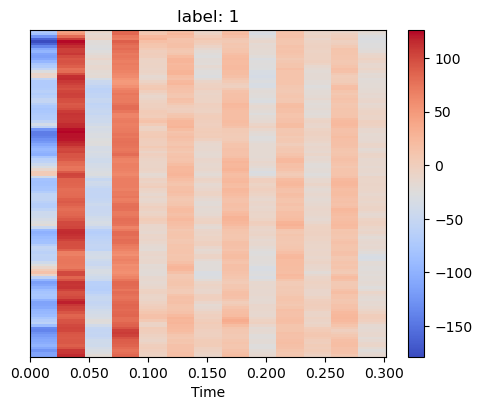

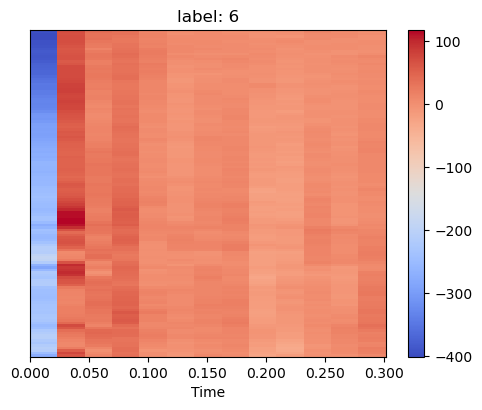

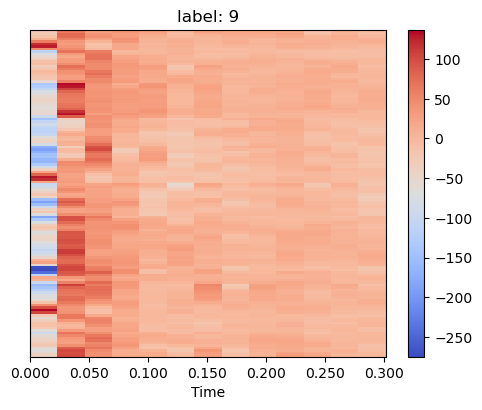

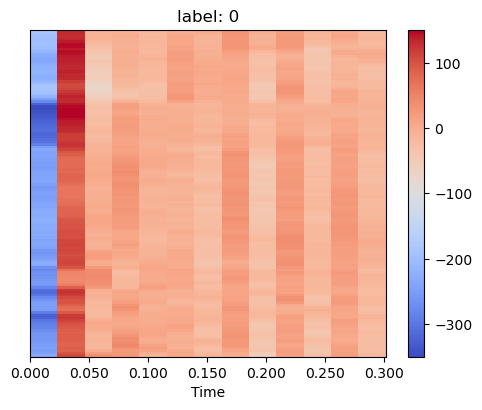

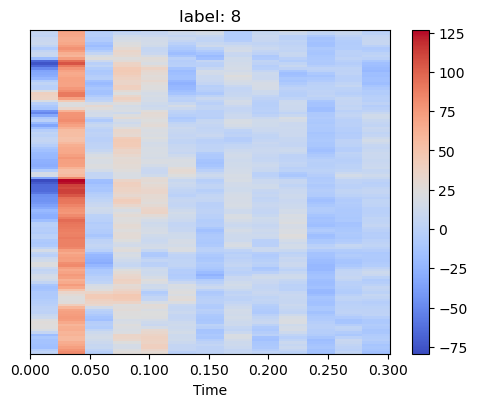

In [164]:
#visualizing
for _ in range(5):
    n = random.randint(0,X.shape[0])
    example = X[n,:,:]
    label = y[n]
    plt.figure(figsize=(5,4))
    librosa.display.specshow(example, x_axis='time')
    plt.colorbar()
    plt.tight_layout()
    plt.title('label: {}'.format(label))
    plt.show()

In [165]:
num_classes = np.unique(y)
X = X[:,np.newaxis,...]
print(X.shape)

(9986, 1, 130, 13)


In [166]:
# X_train, X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [167]:
class CNN(nn.Module):
    def __init__(self,num_classes,in_channels = 1,rate = 0.5):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels,out_channels = 32,kernel_size = (3,3))
        self.pool1 = nn.MaxPool2d(kernel_size = (3,3),stride = (2,2))
        self.bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels = 32,out_channels = 16, kernel_size = (3,3))
        self.pool2 = nn.MaxPool2d(kernel_size = (3,3),stride = (2,2))
        self.bn1 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*30*1,64)
        self.fc2 = nn.Linear(64,num_classes)
        self.dropout = nn.Dropout(p = rate)
    def forward(self,x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.bn(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.bn1(x)
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = nn.functional.softmax(x,dim = 1)
        return x

In [168]:
#Testing CNN Class
model1 = CNN(in_channels = 1,num_classes = num_classes.shape[0])
x = torch.randn(32,1,130,13)
print(model1(x).shape)

torch.Size([32, 10])


In [169]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.x = X
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        sample_x = self.x[idx,:,:,:]
        sample_y = self.y[idx]
        sample = {'x':torch.tensor(sample_x,dtype = torch.long),
                  'y':torch.tensor(sample_y,dtype = torch.long)}
        return sample

In [170]:
dataset = CustomDataset(X,y)

In [171]:
train_split = math.ceil(len(dataset) * 0.8)
val_split = len(dataset) - train_split
print('The size of the training set will be {}'.format(train_split))
print('The size of the validation set will be {}'.format(val_split))

The size of the training set will be 7989
The size of the validation set will be 1997


In [172]:
train_set,val_set = torch.utils.data.random_split(dataset,[train_split,val_split])
print(len(train_set))
print(len(val_set))

7989
1997


In [173]:
train_dataloader = torch.utils.data.DataLoader(train_set,
                                               batch_size = batch_size,
                                               shuffle = True,
                                               drop_last = True)
validation_dataloader = torch.utils.data.DataLoader(val_set, 
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    drop_last = True)

In [174]:
for batch in train_dataloader:
    break
for eval_batch in validation_dataloader:
    break
print(batch['x'].shape)
print(batch['y'].shape)
print(eval_batch['x'].shape)
print(eval_batch['y'].shape)

torch.Size([128, 1, 130, 13])
torch.Size([128])
torch.Size([128, 1, 130, 13])
torch.Size([128])


In [175]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(in_channels = 1, num_classes = num_classes.shape[0])
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [176]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [177]:
def check_accuracy(model,loader):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for batch in loader:
            x,y = batch.values()
            x = x.float()
            x = x.to(device)
            y = y.to(device)
            score = model(x)
            _,predictions = score.max(1)
            num_correct += (predictions==y).sum()
            num_samples += predictions.size(0)
    accuracy = num_correct/num_samples
    model.train()
    return accuracy

In [178]:
epoch_loss = []
epoch_accuracy = []
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    samples = 0
    for batch in train_dataloader:
        x,y = batch.values()
        x = x.float()
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        y_pred = torch.argmax(outputs,dim = 1)
        loss = criterion(outputs,y)
        running_loss += loss.item() 
        correct = (y_pred==y).sum()
        samples = y_pred.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(train_dataloader)
    epoch_loss.append(train_loss)
    acc = correct/samples
    epoch_accuracy.append(acc)
    print(100*'-')
    print('Epoch:{}====>Loss:{:.4f} ----- training accuracy:{:.4f}'.format(epoch+1,train_loss,acc))

----------------------------------------------------------------------------------------------------
Epoch:1====>Loss:2.2570 ----- training accuracy:0.2578
----------------------------------------------------------------------------------------------------
Epoch:2====>Loss:2.1955 ----- training accuracy:0.3281
----------------------------------------------------------------------------------------------------
Epoch:3====>Loss:2.1450 ----- training accuracy:0.2266
----------------------------------------------------------------------------------------------------
Epoch:4====>Loss:2.1158 ----- training accuracy:0.3594
----------------------------------------------------------------------------------------------------
Epoch:5====>Loss:2.0968 ----- training accuracy:0.4141
----------------------------------------------------------------------------------------------------
Epoch:6====>Loss:2.0790 ----- training accuracy:0.3984
----------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Epoch:54====>Loss:1.8181 ----- training accuracy:0.6250
----------------------------------------------------------------------------------------------------
Epoch:55====>Loss:1.8137 ----- training accuracy:0.6875
----------------------------------------------------------------------------------------------------
Epoch:56====>Loss:1.8167 ----- training accuracy:0.6328
----------------------------------------------------------------------------------------------------
Epoch:57====>Loss:1.8179 ----- training accuracy:0.6641
----------------------------------------------------------------------------------------------------
Epoch:58====>Loss:1.8145 ----- training accuracy:0.6875
----------------------------------------------------------------------------------------------------
Epoch:59====>Loss:1.8121 ----- training accuracy:0.6875
----------------------------------------------------------

----------------------------------------------------------------------------------------------------
Epoch:107====>Loss:1.7605 ----- training accuracy:0.7422
----------------------------------------------------------------------------------------------------
Epoch:108====>Loss:1.7649 ----- training accuracy:0.6875
----------------------------------------------------------------------------------------------------
Epoch:109====>Loss:1.7626 ----- training accuracy:0.8125
----------------------------------------------------------------------------------------------------
Epoch:110====>Loss:1.7571 ----- training accuracy:0.6953
----------------------------------------------------------------------------------------------------
Epoch:111====>Loss:1.7629 ----- training accuracy:0.6562
----------------------------------------------------------------------------------------------------
Epoch:112====>Loss:1.7549 ----- training accuracy:0.6953
----------------------------------------------------

In [179]:
check_accuracy(model,validation_dataloader)

tensor(0.7255, device='cuda:0')